In [239]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import pearsonr
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
register_matplotlib_converters()
from time import time
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.ardl import ardl_select_order
import warnings
from statsmodels.tsa.api import ARDL
import datetime

In [241]:
# Set date range
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019,12,31)
#end = datetime.datetime.today()

In [243]:
# FRED codes:
# 3-Month Treasury Bill Rate: 'TB3MS'
# 10-Year Treasury Constant Maturity Rate: 'GS10'

# Fetch data
t_bill_3m = web.DataReader('TB3MS', 'fred', start, end)
t_bond_10y = web.DataReader('GS10', 'fred', start, end)
gdp = web.DataReader('GDP','fred',start,end)

# Combine into one DataFrame
yield_data = pd.concat([t_bill_3m, t_bond_10y], axis=1)
yield_data.columns = ['3M T-Bill', '10Y Bond']

# Drop rows with missing values
yield_data.dropna(inplace=True)
gdp.dropna(inplace = True)

<Axes: title={'center': '3-Month T-Bill vs 10-Year Treasury Bond Yield'}, xlabel='DATE'>

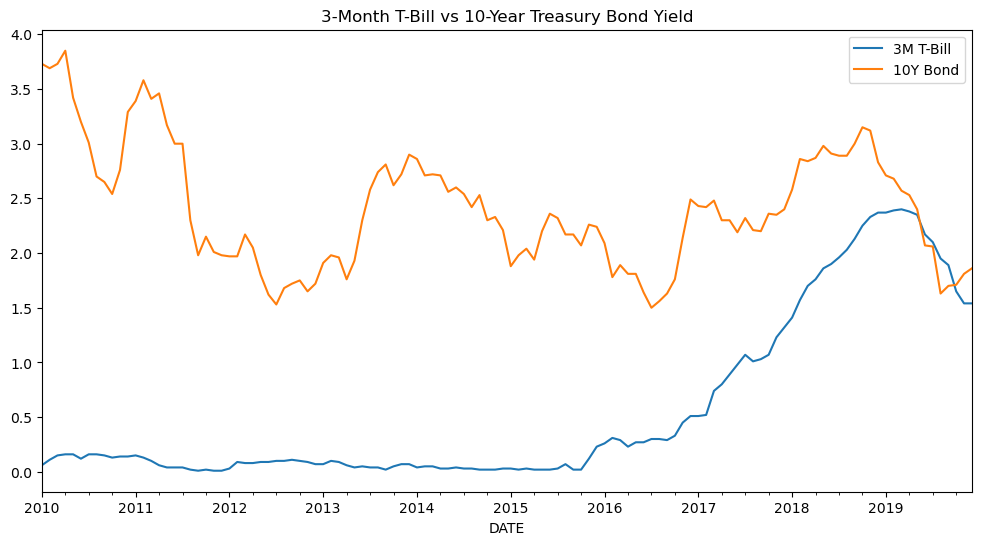

In [244]:
yield_data.plot(title='3-Month T-Bill vs 10-Year Treasury Bond Yield', figsize=(12,6))

In [247]:
yield_data['term_spread'] = yield_data['10Y Bond'] - yield_data['3M T-Bill']
yield_data.head()

,3M T-Bill,10Y Bond,term_spread
DATE,,,
2010-01-01,0.06,3.73,3.67
2010-02-01,0.11,3.69,3.58
2010-03-01,0.15,3.73,3.58
2010-04-01,0.16,3.85,3.69
2010-05-01,0.16,3.42,3.26


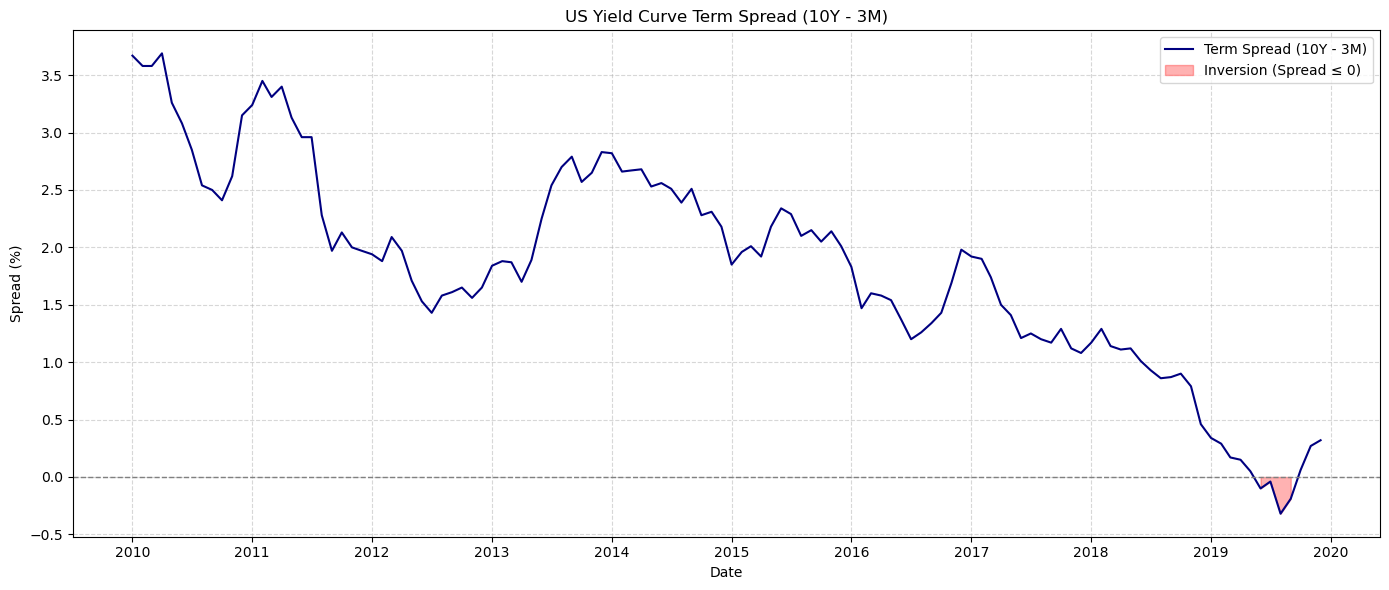

In [249]:
inversion = yield_data['term_spread'] <= 0

# Step 3: Plot with shaded regions
plt.figure(figsize=(14,6))
plt.plot(yield_data.index, yield_data['term_spread'], label='Term Spread (10Y - 3M)', color='navy')

# Shade inversion areas
plt.fill_between(yield_data.index, yield_data['term_spread'], 
                 where=inversion, color='red', alpha=0.3, label='Inversion (Spread ≤ 0)')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('US Yield Curve Term Spread (10Y - 3M)')
plt.ylabel('Spread (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [255]:
gdp.reset_index(inplace = True)
yield_data.reset_index(inplace = True)

In [261]:
df = pd.merge(gdp,yield_data,on = ['DATE'],how = 'left')
df.set_index('DATE',inplace = True)
df.head()

,GDP,3M T-Bill,10Y Bond,term_spread
DATE,,,,
2010-01-01,14764.610,0.06,3.73,3.67
2010-04-01,14980.193,0.16,3.85,3.69
2010-07-01,15141.607,0.16,3.01,2.85
2010-10-01,15309.474,0.13,2.54,2.41
2011-01-01,15351.448,0.15,3.39,3.24


In [263]:
df = df.resample('QE').mean()
df.head()

,GDP,3M T-Bill,10Y Bond,term_spread
DATE,,,,
2010-03-31,14764.610,0.06,3.73,3.67
2010-06-30,14980.193,0.16,3.85,3.69
2010-09-30,15141.607,0.16,3.01,2.85
2010-12-31,15309.474,0.13,2.54,2.41
2011-03-31,15351.448,0.15,3.39,3.24


In [265]:
def check_stationarity(series, alpha=0.05, verbose=True):
    """
    Performs ADF & KPSS test to check stationarity of a time series.
    
    Parameters:
        series (pd.Series): The time series data.
        alpha (float): Significance level (default 0.05).
        verbose (bool): Whether to print detailed output.
    
    Prints:
        Results of the ADF test & KPSS test
    """
    result = adfuller(series.dropna(), autolag='AIC')
    output = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Used Lags': result[2],
        'Number of Observations': result[3],
        'Critical Values': result[4],
        'Stationary': result[1] < alpha
    }

    if verbose:
        print("=== ADF Test Results ===")
        print(f"ADF Statistic     : {output['ADF Statistic']:.4f}")
        print(f"p-value           : {output['p-value']:.4f}")
        print(f"Used Lags         : {output['Used Lags']}")
        print(f"Observations Used : {output['Number of Observations']}")
        print("Critical Values   :")
        for key, value in output['Critical Values'].items():
            print(f"   {key} : {value:.4f}")
    result = kpss(series.dropna())
    output = {
        'KPSS Statistic': result[0],
        'p-value': result[1],
        'Used Lags': result[2],
        'Critical Values': result[3],
        'Stationary': result[1] < alpha
    }

    if verbose:
        print("=== KPSS Test Results ===")
        print(f"KPSS Statistic     : {output['KPSS Statistic']:.4f}")
        print(f"p-value           : {output['p-value']:.4f}")
        print(f"Used Lags         : {output['Used Lags']}")
        print("Critical Values   :")
        for key, value in output['Critical Values'].items():
            print(f"   {key} : {value:.4f}")


In [269]:
check_stationarity(df['GDP'])

=== ADF Test Results ===
ADF Statistic     : 2.3240
p-value           : 0.9990
Used Lags         : 0
Observations Used : 39
Critical Values   :
   1% : -3.6104
   5% : -2.9391
   10% : -2.6081
=== KPSS Test Results ===
KPSS Statistic     : 0.9052
p-value           : 0.0100
Used Lags         : 4
Critical Values   :
   10% : 0.3470
   5% : 0.4630
   2.5% : 0.5740
   1% : 0.7390


/var/folders/s6/gx_5y31n3859mrts2l3mbgkh0000gn/T/ipykernel_81745/3577381164.py:32: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna())


In [271]:
def plot_acf_pacf(series, lags=10, alpha=0.05, title_prefix=''):
    """
    Plots the ACF and PACF of a time series.

    Parameters:
        series (pd.Series): The time series data.
        lags (int): Number of lags to show.
        alpha (float): Confidence interval level.
        title_prefix (str): Prefix to add to the plot titles.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    plot_acf(series, lags=lags, ax=axes[0], alpha=alpha)
    axes[0].set_title(f'{title_prefix} ACF')

    plot_pacf(series, lags=lags, ax=axes[1], alpha=alpha, method='ywm')
    axes[1].set_title(f'{title_prefix} PACF')

    plt.tight_layout()
    plt.show()

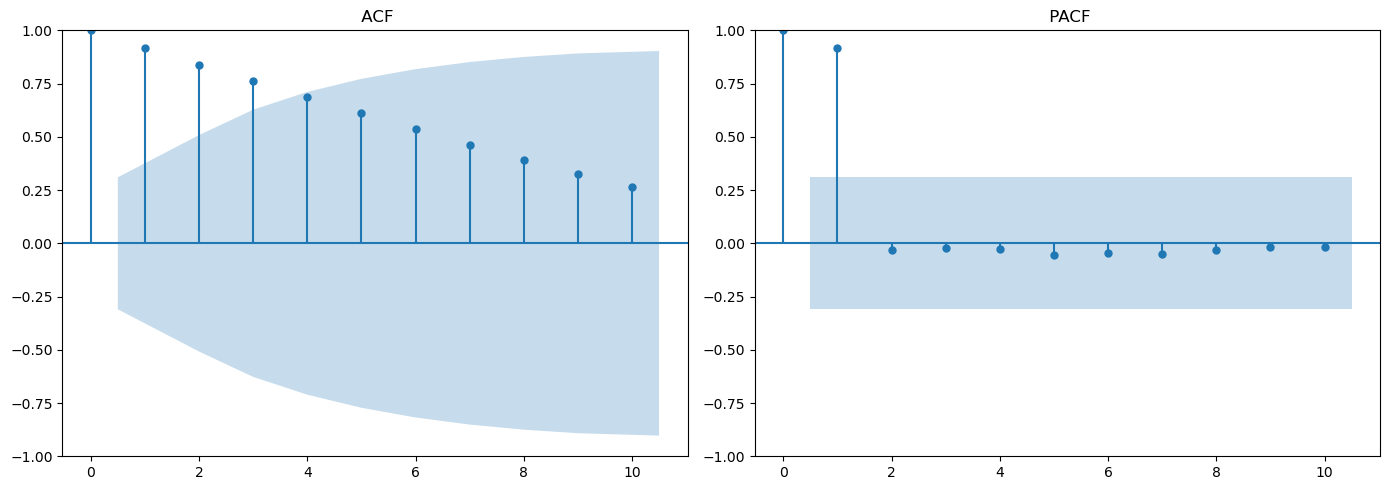

In [273]:
plot_acf_pacf(df['GDP'])

In [275]:
new_df = df.copy()

In [277]:
#new_df['GDP'] = df['GDP'].diff()
new_df.dropna(inplace = True)

In [279]:
new_df.head()

,GDP,3M T-Bill,10Y Bond,term_spread
DATE,,,,
2010-03-31,14764.610,0.06,3.73,3.67
2010-06-30,14980.193,0.16,3.85,3.69
2010-09-30,15141.607,0.16,3.01,2.85
2010-12-31,15309.474,0.13,2.54,2.41
2011-03-31,15351.448,0.15,3.39,3.24


In [281]:
model = ARDL(endog=new_df['GDP'], exog=pd.DataFrame(new_df['term_spread']), lags=1, order = 1)

In [285]:
#Step 2: Fit the model
result = model.fit()

# Step 3: View summary
print(result.summary())

                              ARDL Model Results                              
Dep. Variable:                    GDP   No. Observations:                   40
Model:                     ARDL(1, 1)   Log Likelihood                -223.647
Method:               Conditional MLE   S.D. of innovations             74.858
Date:                Tue, 29 Apr 2025   AIC                            457.293
Time:                        21:11:09   BIC                            465.611
Sample:                    06-30-2010   HQIC                           460.278
                         - 12-31-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -24.4720    283.830     -0.086      0.932    -600.678     551.734
GDP.L1             1.0122      0.013     77.811      0.000       0.986       1.039
term_spread.L0   -14.1686     38.333

In [287]:
selected_model = ardl_select_order(endog=new_df['GDP'],
                                   exog=pd.DataFrame(new_df['term_spread']),
                                   maxlag=4,
                                   maxorder = 4,
                                   ic='aic')

print(selected_model.model)  # Chosen lag structure
result = selected_model.model.fit()
print(result.summary())

                              ARDL Model Results                              
Dep. Variable:                    GDP   No. Observations:                   40
Model:                     ARDL(1, 4)   Log Likelihood                -216.023
Method:               Conditional MLE   S.D. of innovations             61.566
Date:                Tue, 29 Apr 2025   AIC                            448.046
Time:                        21:11:09   BIC                            461.355
Sample:                    03-31-2011   HQIC                           452.821
                         - 12-31-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            157.6949    324.353      0.486      0.630    -502.991     818.381
GDP.L1             1.0056      0.014     70.447      0.000       0.976       1.035
term_spread.L0   -33.6944     38.612

##GDP = 1.0056 * GDPt-1 -108.8134*term_spreadt-2 + 162.66*term_spreadt-3 -110.6461*term_spreadt-4

In [292]:
term_spread_coeff = [-108.813,162.6632,-110.6461]
gdp_coeff = [1.0056]

In [304]:
test = new_df.loc['2018-12-31':][['GDP','term_spread']]

In [314]:
def predict_gdp_from_custom_ardl(df,term_spread_coeff,gdp_coeff):
    """
    Predicts GDP using a manually specified ARDL(1, [2,3,4]) equation.

    Equation:
    GDP_t = 1.0056 * GDP_{t-1}
            -108.8134 * Spread_{t-2}
            +162.66   * Spread_{t-3}
            -110.6461 * Spread_{t-4}

    Args:
        df (pd.DataFrame): DataFrame with 'GDP' and 'Term Spread' columns.
        term_spread_coeff (list): List with term_spread coefficients
        gdp (list): List with gdp coefficients
        
    Returns:
        pd.Series: Predicted GDP values.
    """
    pred = (
        gdp_coeff[0]    * df['GDP'].shift(1) +
       term_spread_coeff[0]  * df['term_spread'].shift(2) +
        term_spread_coeff[1]    * df['term_spread'].shift(3) +
       term_spread_coeff[2]  * df['term_spread'].shift(4)
    )

    return pred

In [318]:
# Assume macro_df contains 'GDP' and 'Term Spread'
new_df['Predicted GDP'] = predict_gdp_from_custom_ardl(new_df,term_spread_coeff,gdp_coeff)

# Drop NA rows (due to lag)
new_df.dropna(inplace=True)

# View
print(new_df[['GDP', 'Predicted GDP']])

                  GDP  Predicted GDP
DATE                                
2011-03-31  15351.448   15279.246025
2011-06-30  15557.539   15230.482790
2011-09-30  15647.680   15368.784025
2011-12-31  15842.259   15625.714475
2012-03-31  16068.805   15803.450686
2012-06-30  16207.115   16032.304950
2012-09-30  16319.541   16105.737784
2012-12-31  16420.419   16276.459235
2013-03-31  16648.189   16462.563826
2013-06-30  16728.687   16576.512967
2013-09-30  16953.838   16732.322084
2013-12-31  17192.019   16980.531616
2014-03-31  17197.738   17084.847902
2014-06-30  17518.508   17239.462081
2014-09-30  17804.228   17446.762315
2014-12-31  17912.079   17786.662584
2015-03-31  18063.529   17863.181386
2015-06-30  18279.784   18028.344206
2015-09-30  18401.626   18273.997125
2015-12-31  18435.137   18344.407958
2016-03-31  18525.933   18396.810056
2016-06-30  18711.702   18566.669791
2016-09-30  18892.639   18697.439732
2016-12-31  19089.379   18897.362389
2017-03-31  19280.084   19120.229415
2

<Axes: xlabel='DATE'>

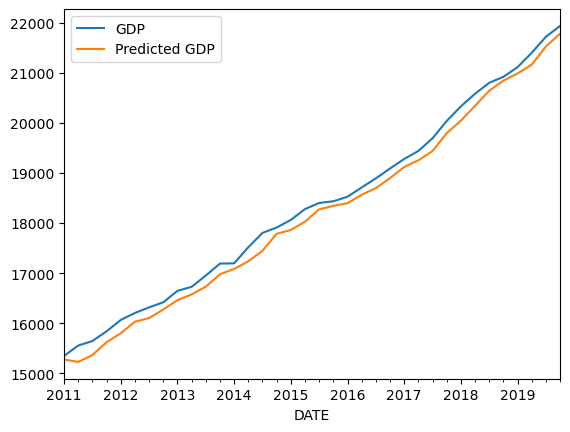

In [320]:
new_df[['GDP','Predicted GDP']].plot()